In [1]:
### Importing Libraries ###

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# For mathematical operations
import numpy as np

# For deep copy of data structures
import copy

# Data manipulation library
import pandas as pd

# Libraries for visualization

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Project Summary:

Feed-Forward Neural network 

We developed a deep learning model using the UCI Wine Quality dataset to impute missing values for the "residual sugar" content in wines.

Key Steps:

1. Data Loading: Imported the dataset directly from the UCI repository.

2. Data Preprocessing:

- Normalized the entire dataset using z-score normalization.
- Randomly set 10 data points in the "residual sugar" column to NaN for testing.
- Divided the data into training (excluding NaNs) and testing (only NaNs) sets.

3. Model Architecture:

- Input Layer: 11 neurons (matching the number of features)
- Hidden Layers: Two layers with 16 and 32 neurons respectively
- Output Layer: Single neuron (for predicting "residual sugar")

4. Training:

- Loss Function: Mean Squared Error (MSE)
- Optimizer: Adam with a learning rate of 0.01
- Epochs: 400

5. Evaluation:

- Used Pearson correlation to assess model predictions.
- Achieved correlations of r=0.985 for training data and r=0.864 for testing data.

Parameters & Configuration:

Batch Size: 32
Learning Rate: 0.01
Epochs: 400

In [2]:
### Data Loading and Preprocessing ###

# Importing data from the UCI repository
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Normalizing columns via Z-scoring (mean=0 and variance=1)
data = (data - data.mean()) / data.std(ddof=1)

# Making a deep copy of the data as a backup
dataOrig = copy.deepcopy(data)

# Setting random data points as missing for experimental purposes
n2nan = 10
whichVals2nan = np.random.choice(range(len(data)), size=n2nan, replace=False)
data['residual sugar'][whichVals2nan] = np.nan

# Identifying which values are not NaN for training
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

# Display missing values info for confirmation
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 444  475  505  806  888 1130 1194 1287 1358 1368]
[ 444  475  505  806  888 1130 1194 1287 1358 1368]


In [3]:
# Preparing data tensors for Deep Learning
cols2keep = data.keys().drop('residual sugar')

# Training data tensors
train_dataT  = torch.tensor(data[cols2keep].values).float()
train_dataT  = train_dataT[whichValsNotNan, :]
train_labelT = torch.tensor(data['residual sugar'].values).float()
train_labelT = train_labelT[whichValsNotNan, None]

# Test data tensors
test_dataT  = torch.tensor(dataOrig[cols2keep].values).float()
test_dataT  = test_dataT[whichVals2nan, :]
test_labelT = torch.tensor(dataOrig['residual sugar'].values).float()
test_labelT = test_labelT[whichVals2nan, None]

# Confirming tensor shapes
print(f'Original data: {data.shape}\nTrain data: {train_dataT.shape}\nTrain labels: {train_labelT.shape}\nTest data: {test_dataT.shape}\nTest labels: {test_labelT.shape}')

# Creating PyTorch Dataset for batching and data loading during training
train_dataDataset = TensorDataset(train_dataT, train_labelT)

# Dataloader object for batched training
batchsize = 32
train_data = DataLoader(train_dataDataset, batch_size=batchsize, shuffle=True, drop_last=True)

Original data: (1599, 12)
Train data: torch.Size([1589, 11])
Train labels: torch.Size([1589, 1])
Test data: torch.Size([10, 11])
Test labels: torch.Size([10, 1])


In [4]:
### Neural Network Definition ###

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer: 11 features going to 16 units
        self.input = nn.Linear(11, 16)
        
        # Hidden layers: two layers with 32 units each
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        # Output layer: 32 units to 1 output
        self.output = nn.Linear(32, 1)

    # Forward propagation
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [5]:
### Model Training Function ###

numepochs = 400

def trainTheModel():
    # Loss function (Mean Squared Error for regression tasks)
    lossfun = nn.MSELoss()
    
    # Optimizer (Adam) for weight updates
    optimizer = torch.optim.Adam(winenet.parameters(), lr=.01)

    # Initializing a tensor to store loss values
    trainLoss = torch.zeros(numepochs)

    # Iterating over epochs
    for epochi in range(numepochs):
        batchLoss = []

        # Iterating over data batches
        for X, y in train_data:
            # Forward pass
            yHat = winenet(X)
            
            # Computing loss
            loss = lossfun(yHat, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Storing the loss of this batch
            batchLoss.append(loss.item())

        # Averaging losses across batches for this epoch
        trainLoss[epochi] = np.mean(batchLoss)
  
    return trainLoss

In [6]:
### Model Initialization and Training ###

winenet = ANNwine()
trainLoss = trainTheModel()

### Evaluation ###

# Setting the model to evaluation mode for inference
winenet.eval()

# Getting predictions without computing gradients for efficiency
with torch.no_grad():
    yHatTrain = winenet(train_dataT)
    yHatTest  = winenet(test_dataT)

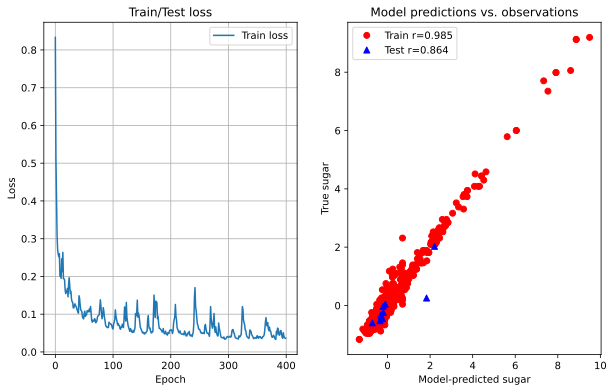

In [7]:
### Visualization ###

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Training loss curve
ax[0].plot(trainLoss, label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

# Model's predictions vs true values
ax[1].plot(yHatTrain.detach(), train_labelT, 'ro')
ax[1].plot(yHatTest.detach(), test_labelT, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# Computing correlation for predictions vs true values
corrTrain = np.corrcoef(yHatTrain.detach().T, train_labelT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelT.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}'])

Interpretation of Model Performance:

We evaluated the model's accuracy using the Pearson correlation coefficient:

Training Data (r=0.985):
This near-perfect correlation indicates the model's predictions closely match the training data.

Testing Data (r=0.864):
Although slightly lower than the training data correlation, this high value demonstrates the model's strong generalization on unseen data.

The slight difference between training and test correlations suggests a potential mild overfitting. Continued monitoring and possible model adjustments are recommended.

The data had no missing values, however the code snippet below demonstrates the steps that I would then take to fill in missing data after I have trained the model.  

To make predictions on the 5 missing data points in the dataset:

In [ ]:
# Step 1: Extract the 5 missing data points
missing_data_points = data[data['residual sugar'].isna()].head(5)

# Drop the 'residual sugar' column since it contains NaN values
cols_to_keep = missing_data_points.keys().drop('residual sugar')
missing_data = missing_data_points[cols_to_keep]

# Step 2: Convert to PyTorch tensors
missing_data_tensor = torch.tensor(missing_data.values).float()

# Step 3: Feed them to the trained model (ensure the model is in eval mode)
winenet.eval()
predicted_sugar = winenet(missing_data_tensor)

# Step 4: Convert the predictions back to numpy for better readability
predicted_sugar_numpy = predicted_sugar.detach().numpy()

print(predicted_sugar_numpy)


This code snippet will replace the NaN values in the residual sugar column of the data DataFrame with the predicted values for the first 5 missing data points. 

In [ ]:

# Step 1: Get the indices of the rows with missing values
missing_indices = missing_data_points.index

# Step 2: Replace NaN values in the DataFrame with the predicted values
for idx, value in zip(missing_indices, predicted_sugar_numpy):
    data.at[idx, 'residual sugar'] = value[0]  # the [0] is used because predicted_sugar_numpy is a 2D array

# To verify that the NaN values have been replaced
print(data.loc[missing_indices])


Conclusion:

The current model shows potential but has room for improvement. Exploring techniques like batch normalization and dropout might enhance its performance. While these adjustments were not pursued in this project, they set a clear direction for future endeavors.

Below is ANNwine class modified to include dropout and batch normalisation. 

In [ ]:
class ANNwineWithDropoutAndBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

        # Dropout layer (0.3 indicates 30% of the neurons will be dropped during training)
        self.dropout = nn.Dropout(0.3)
        
        ### Input layer
        # Linear transformation of input data to a 16-dimensional space
        self.input = nn.Linear(11,16)
        # Batch normalization after input layer to stabilize activations
        self.bn_input = nn.BatchNorm1d(16)

        ### First hidden layer
        # Transforming the 16-dimensional input to a 32-dimensional space
        self.fc1 = nn.Linear(16,32)
        # Batch normalization after first hidden layer
        self.bn1 = nn.BatchNorm1d(32)
        
        ### Second hidden layer
        # Transforming the 32-dimensional data from the previous layer to another 32-dimensional space
        self.fc2 = nn.Linear(32,32)
        # Batch normalization after second hidden layer
        self.bn2 = nn.BatchNorm1d(32)

        ### Output layer
        # Transforming the 32-dimensional data from the previous layer to a single-dimensional output
        self.output = nn.Linear(32,1)
  
    # Forward pass
    def forward(self, x):
        # Applying the input layer transformation, followed by batch normalization, ReLU activation, and dropout
        x = F.relu(self.bn_input(self.input(x)))
        x = self.dropout(x)
        
        # Applying the first hidden layer transformation, followed by batch normalization, ReLU activation, and dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        # Applying the second hidden layer transformation, followed by batch normalization, ReLU activation, and dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        # Getting the final output
        return self.output(x)
